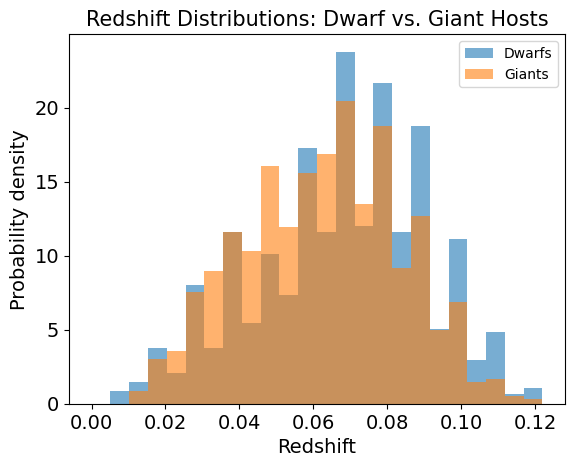

In [16]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/jovyan/research/Current/supernova_hosts_classified.csv')
dwarfs = df[df['galaxy_type']=='dwarf']
giants = df[df['galaxy_type']=='giant']


import matplotlib.pyplot as plt

bins = np.linspace(0, 0.122, 25)
plt.hist(dwarfs['redshift'], bins=bins, alpha=0.6, density=True, label='Dwarfs')
plt.hist(giants ['redshift'], bins=bins, alpha=0.6, density=True, label='Giants')
plt.xlabel('Redshift',fontsize=14)
plt.ylabel('Probability density',fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title('Redshift Distributions: Dwarf vs. Giant Hosts',fontsize=15)
plt.savefig('redshift_dist_galaxy.png')
plt.legend()







In [6]:
ks_stat = ks_2samp(dwarfs['redshift'], giants['redshift'])
print(ks_stat)


KstestResult(statistic=0.1364178457201713, pvalue=1.697071214993498e-12, statistic_location=0.07996, statistic_sign=-1)


Wrote 200 rows to field1746_efficiencies.csv


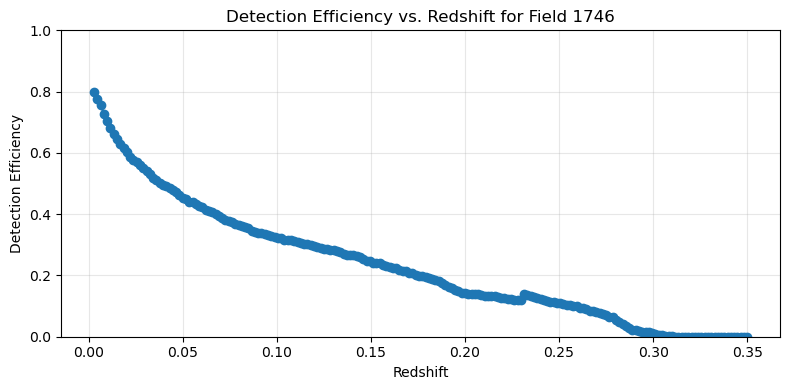

In [8]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Find all result files for field 1746
file_pattern = os.path.join("/home/jovyan/research/Current/Sim_results", "1746_z*.dat")
files = glob.glob(file_pattern)

if not files:
    print(f"No files found matching pattern: {file_pattern}")
else:
    # 2) Extract redshift values from filenames and compute efficiencies
    zs = []
    efficiencies = []
    for fname in files:
        basename = os.path.basename(fname)
        z_str = basename.split("_z")[1].split(".dat")[0]
        z_val = float(z_str)
        df = pd.read_csv(fname, comment="#")
        eff = (df["detections"] > 0).mean()
        zs.append(z_val)
        efficiencies.append(eff)

    # 3) Sort by redshift
    zs, efficiencies = zip(*sorted(zip(zs, efficiencies)))

    # 4) Save to CSV
    out_df = pd.DataFrame({
        "redshift": zs,
        "efficiency": efficiencies
    })
    out_df.to_csv("field1746_efficiencies.csv", index=False)
    print("Wrote", len(out_df), "rows to field1746_efficiencies.csv")

    # 5) (Optional) Plot
    plt.figure(figsize=(8, 4))
    plt.plot(zs, efficiencies, marker="o", linestyle="-")
    plt.xlabel("Redshift")
    plt.ylabel("Detection Efficiency")
    plt.title("Detection Efficiency vs. Redshift for Field 1746")
    plt.ylim(0, 1)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


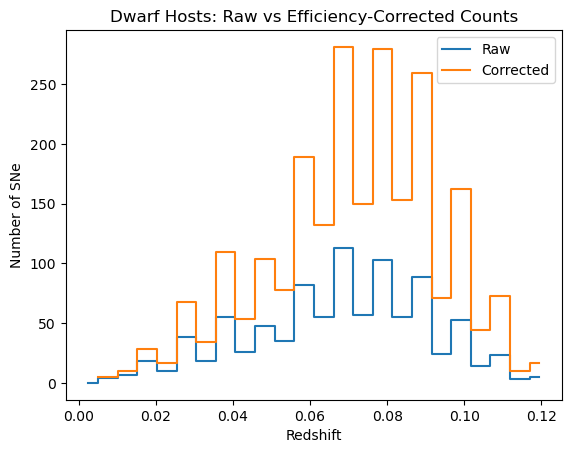

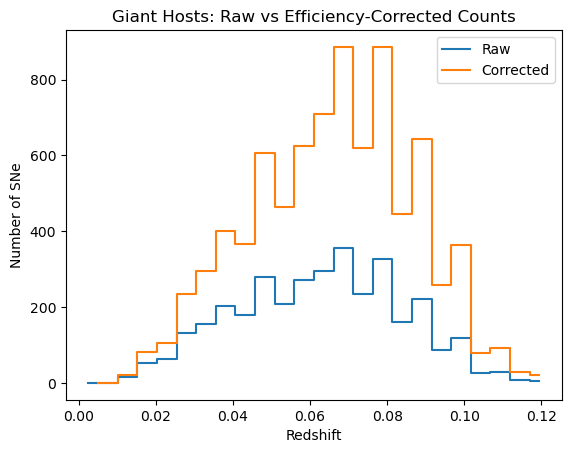

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the supernova hosts data
hosts = pd.read_csv('/home/jovyan/research/Current/supernova_hosts_classified.csv')
dwarfs = hosts[hosts['galaxy_type'] == 'dwarf']
giants = hosts[hosts['galaxy_type'] == 'giant']

# Load the efficiency vs redshift table
eff = pd.read_csv('/home/jovyan/research/Current/field1746_efficiencies.csv')

# Define redshift bins & centers
bins = np.linspace(0, 0.122, 25)
z_mid = (bins[:-1] + bins[1:]) / 2

# Count observed SNe per bin for each host type
dwarf_counts = np.histogram(dwarfs['redshift'], bins=bins)[0]
giant_counts = np.histogram(giants['redshift'], bins=bins)[0]

# Build a DataFrame of counts
counts_df = pd.DataFrame({
    'z_mid': z_mid,
    'dwarf_N_obs': dwarf_counts,
    'giant_N_obs': giant_counts
})

# Merge in efficiency: align on nearest redshift value
eff_sorted = eff.sort_values('redshift').reset_index(drop=True)
counts_df = pd.merge_asof(
    counts_df.sort_values('z_mid'),
    eff_sorted,
    left_on='z_mid',
    right_on='redshift'
)

# Compute efficiency-corrected counts
counts_df['dwarf_N_corr'] = counts_df['dwarf_N_obs'] / counts_df['efficiency']
counts_df['giant_N_corr'] = counts_df['giant_N_obs'] / counts_df['efficiency']

# Plot for dwarfs: raw vs corrected
plt.figure()
plt.step(counts_df['z_mid'], counts_df['dwarf_N_obs'], where='mid', label='Raw')
plt.step(counts_df['z_mid'], counts_df['dwarf_N_corr'], where='mid', label='Corrected')
plt.xlabel('Redshift')
plt.ylabel('Number of SNe')
plt.title('Dwarf Hosts: Raw vs Efficiency-Corrected Counts')
plt.legend()
plt.show()

# Plot for giants: raw vs corrected
plt.figure()
plt.step(counts_df['z_mid'], counts_df['giant_N_obs'], where='mid', label='Raw')
plt.step(counts_df['z_mid'], counts_df['giant_N_corr'], where='mid', label='Corrected')
plt.xlabel('Redshift')
plt.ylabel('Number of SNe')
plt.title('Giant Hosts: Raw vs Efficiency-Corrected Counts')
plt.legend()
plt.show()


In [15]:
import pandas as pd

# Load your host catalog
df = pd.read_csv('/home/jovyan/research/Current/supernova_hosts_classified.csv')

# Coerce hostabs to numeric, dropping any rows that fail conversion
df['hostabs'] = pd.to_numeric(df['hostabs'], errors='coerce')
df = df.dropna(subset=['hostabs'])

# Solar absolute magnitude in the i-band
M_sun_i = 4.08

# Compute each host’s i-band luminosity in solar units
df['L_i'] = 10**(-0.4 * (df['hostabs'] - M_sun_i))

# Separate dwarfs and giants
dwarfs = df[df['galaxy_type'] == 'dwarf']
giants = df[df['galaxy_type'] == 'giant']

# Total integrated light
L_dwarfs = dwarfs['L_i'].sum()
L_giants = giants['L_i'].sum()

# SN counts
N_dwarfs = len(dwarfs)
N_giants = len(giants)

# Ratios
R_L    = L_giants / L_dwarfs      # light ratio
R_N    = N_giants   / N_dwarfs    # SN count ratio
R_spec = R_N        / R_L         # SN per unit light

print(f"Light ratio (giants/dwarfs): {R_L:.2f}")
print(f"SN count ratio (giants/dwarfs):   {R_N:.2f}")
print(f"Specific SN rate ratio:           {R_spec:.2f}")



Light ratio (giants/dwarfs): 122.16
SN count ratio (giants/dwarfs):   3.63
Specific SN rate ratio:           0.03


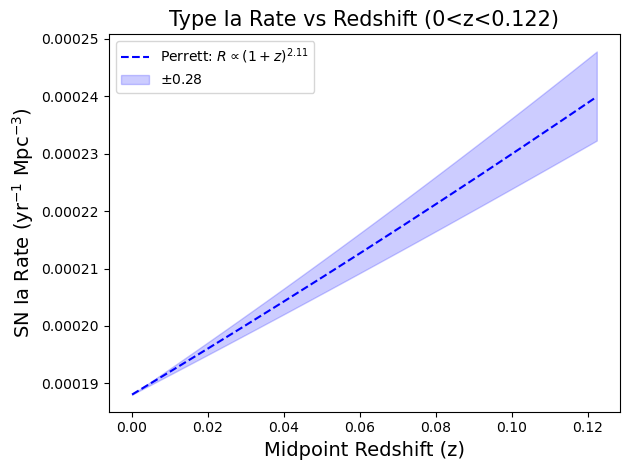

In [36]:
exp_med, exp_err = 2.11, 0.28
z_lit = np.linspace(0, z_max, 200)

# force pivot at first bin
pivot_z = df['z_mid'].values[0]
pivot_R = df['R_per_year'].values[0]
R0      = pivot_R / (1 + pivot_z)**exp_med

# median and ±1σ
R_lit    = R0 * (1 + z_lit)**exp_med
R_lit_hi = R0 * (1 + z_lit)**(exp_med + exp_err)
R_lit_lo = R0 * (1 + z_lit)**(exp_med - exp_err)

plt.plot(z_lit, R_lit, 'b--', label=r'Perrett: $R\propto(1+z)^{2.11}$')
plt.fill_between(z_lit, R_lit_lo, R_lit_hi, color='blue', alpha=0.2,
                 label=r'$\pm0.28$')

plt.xlabel('Midpoint Redshift (z)', fontsize=14)
plt.ylabel('SN Ia Rate (yr$^{-1}$ Mpc$^{-3}$)', fontsize=14)
plt.title(f'Type Ia Rate vs Redshift (0<z<{z_max:.3f})', fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()

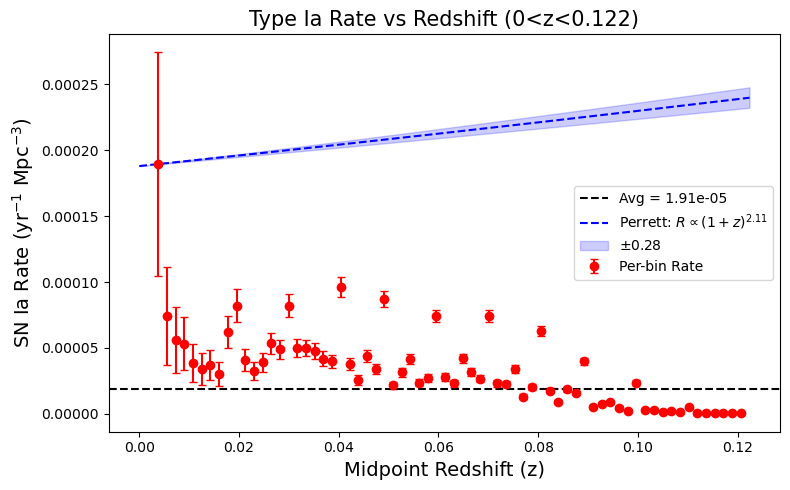

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load your per-bin results into a DataFrame ---
df = pd.read_csv('/home/jovyan/research/Current/per_bin_rates.csv')

# --- Identify redshift cutoff based on first zero-rate bin ---
zeros = df[df['R_shell'] == 0]
if not zeros.empty:
    z_max = zeros['z_mid'].iloc[0]
else:
    z_max = df['z_mid'].max()

# --- Filter to valid bins ---
df = df[(df['R_shell'] > 0) & (df['z_mid'] < z_max)].copy()

# --- Survey time constants ---
T_obs         = 2498.0
days_per_year = 365.25

# --- Compute rest-frame time and per-bin denominator ---
df['T_rest']   = T_obs / (1.0 + df['z_mid'])
df['denom_i']  = df['eff_shell'] * df['T_rest'] * df['shell_volume_Mpc3']

# --- Compute per-bin rates and Poisson errors (annual) ---
df['R_per_day']    = df['sn_count'] / df['denom_i']
df['R_per_year']   = df['R_per_day'] * days_per_year
df['sn_err']       = np.sqrt(df['sn_count'])
df['err_per_day']  = df['sn_err'] / df['denom_i']
df['err_per_year'] = df['err_per_day'] * days_per_year

# --- Aggregate overall rate ---
total_SNe      = df['sn_count'].sum()
sum_denom      = df['denom_i'].sum()
R_agg_per_day  = total_SNe / sum_denom
R_agg_per_year = R_agg_per_day * days_per_year
agg_err_year   = (np.sqrt(total_SNe) / sum_denom) * days_per_year

# --- Plot per-bin rates and overall average ---
plt.figure(figsize=(8,5))
plt.errorbar(df['z_mid'], df['R_per_year'], yerr=df['err_per_year'],
             fmt='o', capsize=3, color='red', label='Per-bin Rate')
plt.axhline(R_agg_per_year, linestyle='--', color='black',
            label=f'Avg = {R_agg_per_year:.2e}')

# --- Overlay literature power-law evolution, pivoted at first bin ---
# literature slope
exp_med, exp_err = 2.11, 0.28
z_lit = np.linspace(0, z_max, 200)

# force pivot at first bin
pivot_z = df['z_mid'].values[0]
pivot_R = df['R_per_year'].values[0]
R0      = pivot_R / (1 + pivot_z)**exp_med

# median and ±1σ
R_lit    = R0 * (1 + z_lit)**exp_med
R_lit_hi = R0 * (1 + z_lit)**(exp_med + exp_err)
R_lit_lo = R0 * (1 + z_lit)**(exp_med - exp_err)

plt.plot(z_lit, R_lit, 'b--', label=r'Perrett: $R\propto(1+z)^{2.11}$')
plt.fill_between(z_lit, R_lit_lo, R_lit_hi, color='blue', alpha=0.2,
                 label=r'$\pm0.28$')

plt.xlabel('Midpoint Redshift (z)', fontsize=14)
plt.ylabel('SN Ia Rate (yr$^{-1}$ Mpc$^{-3}$)', fontsize=14)
plt.title(f'Type Ia Rate vs Redshift (0<z<{z_max:.3f})', fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
print(z_max)

0.1223988190954773


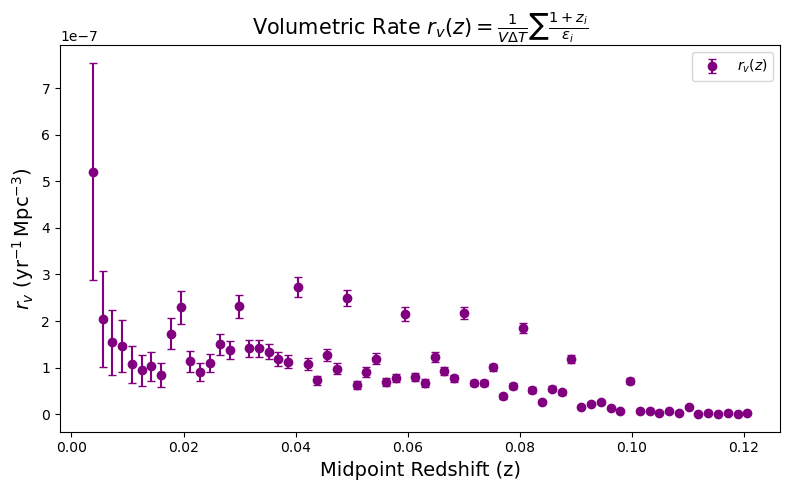

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load per-bin results (adjust filename/path as needed) ---
df = pd.read_csv('/home/jovyan/research/Current/per_bin_rates.csv')

# --- Determine redshift cutoff based on first zero-rate bin ---
zeros = df[df['R_shell'] == 0]
z_max = zeros['z_mid'].iloc[0] if not zeros.empty else df['z_mid'].max()

# --- Filter to valid bins ---
df = df[(df['R_shell'] > 0) & (df['z_mid'] < z_max)].copy()

# --- Survey time constant ---
T_obs = 2498.0  # total survey time in days

# --- Compute rest-frame time per bin ---
df['T_rest'] = T_obs / (1 + df['z_mid'])

# --- New volumetric rate formula: r_v(z) = 1/(V ΔT) ∑((1+z_i)/ε_i) ---
# Approximate sum over i in each bin
df['sum_term'] = df['sn_count'] * (1 + df['z_mid']) / df['eff_shell']

# Compute r_v per bin
df['r_v'] = df['sum_term'] / (df['shell_volume_Mpc3'] * df['T_rest'])

# Uncertainties via Poisson on sn_count
df['sum_err'] = np.sqrt(df['sn_count']) * (1 + df['z_mid']) / df['eff_shell']
df['r_v_err'] = df['sum_err'] / (df['shell_volume_Mpc3'] * df['T_rest'])

# --- Plot r_v vs z ---
plt.figure(figsize=(8,5))
plt.errorbar(df['z_mid'], df['r_v'], yerr=df['r_v_err'],
             fmt='o', capsize=3, color='purple', label=r'$r_v(z)$')
plt.xlabel('Midpoint Redshift (z)', fontsize=14)
plt.ylabel(r'$r_v\ (\mathrm{yr^{-1}\,Mpc^{-3}})$', fontsize=14)
plt.title(r'Volumetric Rate $r_v(z)=\frac{1}{V\Delta T}\sum\frac{1+z_i}{\epsilon_i}$', fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()


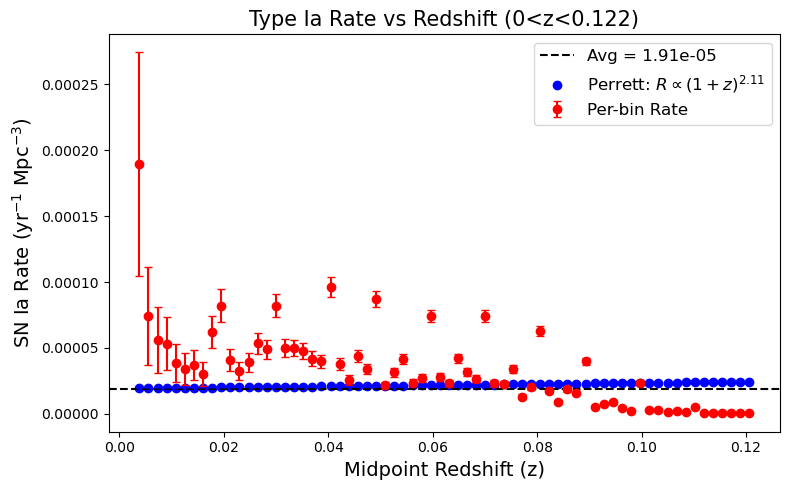

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load your per-bin results into a DataFrame ---
# Replace with your actual file path if different
df = pd.read_csv('/home/jovyan/research/Current/per_bin_rates.csv')

# --- Identify redshift cutoff based on first zero-rate bin ---
zeros = df[df['R_shell'] == 0]
z_max = zeros['z_mid'].iloc[0] if not zeros.empty else df['z_mid'].max()

# --- Filter to valid bins ---
df = df[(df['R_shell'] > 0) & (df['z_mid'] < z_max)].copy()

# --- Survey time constants ---
T_obs, days_per_year = 2498.0, 365.25

# --- Compute rest-frame time and per-bin denominator ---
df['T_rest']  = T_obs / (1.0 + df['z_mid'])
df['denom_i'] = df['eff_shell'] * df['T_rest'] * df['shell_volume_Mpc3']

# --- Compute per-bin rates and Poisson errors (annual) ---
df['R_per_day']    = df['sn_count'] / df['denom_i']
df['R_per_year']   = df['R_per_day'] * days_per_year
df['sn_err']       = np.sqrt(df['sn_count'])
df['err_per_day']  = df['sn_err'] / df['denom_i']
df['err_per_year'] = df['err_per_day'] * days_per_year

# --- Aggregate overall rate at z=0 normalization ---
total_SNe     = df['sn_count'].sum()
sum_denom     = df['denom_i'].sum()
R_agg_per_day = total_SNe / sum_denom
R_agg_per_year= R_agg_per_day * days_per_year

# --- Literature slope and uncertainty ---
exp_med, exp_err = 2.11, 0.28

# --- Compute literature model at each bin midpoint, normalized at z=0 ---
df['R_model']    = R_agg_per_year * (1 + df['z_mid'])**exp_med
df['R_model_hi'] = R_agg_per_year * (1 + df['z_mid'])**(exp_med + exp_err)
df['R_model_lo'] = R_agg_per_year * (1 + df['z_mid'])**(exp_med - exp_err)

# --- Plot per-bin rates ---
plt.figure(figsize=(8,5))
plt.errorbar(df['z_mid'], df['R_per_year'], yerr=df['err_per_year'],
             fmt='o', capsize=3, color='red', label='Per-bin Rate')
plt.axhline(R_agg_per_year, linestyle='--', color='black',
            label=f'Avg = {R_agg_per_year:.2e}')

# --- Overlay literature model points ---
plt.scatter(df['z_mid'], df['R_model'], color='blue',
            label=r'Perrett: $R\propto(1+z)^{2.11}$')
plt.errorbar(df['z_mid'], df['R_model'],
             yerr=[df['R_model']-df['R_model_lo'], df['R_model_hi']-df['R_model']],
             fmt='none', ecolor='blue', alpha=0.4, capsize=3)

# --- Final formatting ---
plt.xlabel('Midpoint Redshift (z)', fontsize=14)
plt.ylabel('SN Ia Rate (yr$^{-1}$ Mpc$^{-3}$)', fontsize=14)
plt.title(f'Type Ia Rate vs Redshift (0<z<{z_max:.3f})', fontsize=15)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('perrett_rate.png')
plt.show()

